# 使用``gluon``预测房价和K折交叉验证 (实战篇)

In [1]:
import mxnet as mx
import numpy as np
import pandas as pd

from mxnet import nd
from mxnet import gluon
from mxnet import autograd
mx.random.seed(1)

ctx = mx.cpu()

%matplotlib inline 
import matplotlib.pyplot as plt

## 加载数据

In [2]:
train_data = pd.read_csv('../data/house_prediction/train.csv')
test_data = pd.read_csv('../data/house_prediction/test.csv')

In [3]:
train_data.shape

(1460, 81)

In [4]:
test_data.shape

(1459, 80)

In [5]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
test_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
X_train, X_test = train_data.loc[:, 'MSSubClass':'SaleCondition'], test_data.loc[:, 'MSSubClass':'SaleCondition']
print(X_train.shape)
print(X_test.shape)

(1460, 79)
(1459, 79)


In [9]:
all_X = pd.concat([X_train, X_test], axis=0)
all_X.shape

(2919, 79)

## 数据预处理

In [10]:
# 标准化
all_dtypes = all_X.dtypes
numeric_feats = all_dtypes[all_dtypes != 'object'].index
all_X[numeric_feats] = all_X[numeric_feats].apply(lambda x : (x - x.mean()) / x.std()) # axis默认是0

In [11]:
all_X = pd.get_dummies(all_X, dummy_na=True)

In [12]:
all_X.shape

(2919, 331)

In [13]:
all_X = all_X.fillna(value=all_X.mean(), axis=0)

In [14]:
all_X.shape

(2919, 331)

In [15]:
num_train = X_train.shape[0]
X_train = all_X[:num_train]
X_test = all_X[num_train:]
y_train = train_data['SalePrice']

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1460, 331)
(1460,)
(1459, 331)


## 转换为``NDArray``

In [17]:
X_train = nd.array(X_train, ctx=ctx)
X_test = nd.array(X_test, ctx=ctx)
y_train = nd.array(y_train, ctx=ctx).reshape((num_train, 1))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(1460, 331)
(1459, 331)
(1460, 1)


## 定义评估函数

[Wikipedia](https://en.wikipedia.org/wiki/Root-mean-square_deviation)

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/197385368628b8495a746f7bd490d3d1cc83e86c">

In [18]:
square_loss = gluon.loss.L2Loss()

def get_rmsd_log(net, X, y):
    clipped_predict = nd.clip(net(X), 1, float('inf'))
    return np.sqrt(2 * nd.sum(square_loss(nd.log(clipped_predict), nd.log(y))).asscalar() / X.shape[0])

In [19]:
import random

def data_iter(batch_size):
    num = X_train.shape[0]
    idx = list(range(num))
    random.shuffle(idx)
    for i in range(0, num, batch_size):
        j = nd.array(idx[i:min(i+batch_size, num)])
        yield X_train.take(j), y_train.take(j)

In [20]:
for (x, y) in data_iter(5):
    print(x.shape)
    print(y.shape)
    break

(5, 331)
(5, 1)


## 训练函数

In [21]:
def get_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Flatten())
        net.add(gluon.nn.Dense(1024, activation="relu"))
        net.add(gluon.nn.Dropout(0.5))
        net.add(gluon.nn.Dense(1))
    return net

def train(net, X_train, y_train, X_test, y_test, epochs, verbose_epoch, batch_size, learning_rate, weight_decay, ctx):    
    net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), 
                                    ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam', 
                            {'learning_rate':learning_rate, 'wd': weight_decay})
    
    train_loss = []
    if X_test is not None:
        test_loss = []
    
    # train
    for epoch in range(epochs):
        cumulative_loss = .0
        for (data, label) in data_iter(batch_size):
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)
            cumulative_loss += nd.sum(loss).asscalar()
        
        cur_train_loss = get_rmsd_log(net, X_train, y_train)
        train_loss.append(cur_train_loss)
        if X_test is not None:
            cur_test_loss = get_rmsd_log(net, X_test, y_test)
            test_loss.append(cur_test_loss)
              
        if epoch > verbose_epoch:
            if X_test is not None:
                print("Epoch %s, Train RMSE loss %s, Test RMSE loss %s." 
                      % (epoch, cur_train_loss, cur_test_loss))
            else:
                print("Epoch %s, Train RMSE loss %s." % (epoch, cur_train_loss))
                
    plt.figure(figsize=(8, 6))
    plt.plot(list(range(len(train_loss))), train_loss)
    plt.legend(['train_loss'])
    if X_test is not None:
        plt.plot(list(range(len(test_loss))), test_loss)
        plt.legend(['train_loss', 'test_loss'])
    plt.show()
    
    if X_test is not None:
        return train_loss[-1], test_loss[-1]
    else:
        return train_loss[-1]

## K折交叉验证

In [22]:
def k_fold_validation(k, X_train, y_train, epochs, verbose_epoch, batch_size, learning_rate, weight_decay, ctx): # 
    patch = num_train // k
    train_loss = .0
    test_loss = .0
    for test_i in range(k):
        cur_val_X = X_train[test_i*patch : min((test_i+1)*patch, num_train)]
        cur_val_y = y_train[test_i*patch : min((test_i+1)*patch, num_train)]
        train_created = False
        for i in range(k):
            if i != test_i:
                tmp_train_X = X_train[i*patch : min((i+1)*patch, num_train)]
                tmp_train_y = y_train[i*patch : min((i+1)*patch, num_train)]
                if not train_created:
                    cur_train_X = tmp_train_X
                    cur_train_y = tmp_train_y
                    train_created = True
                else:
                    cur_train_X = nd.concat(cur_train_X, tmp_train_X, dim=0)
                    cur_train_y = nd.concat(cur_train_y, tmp_train_y, dim=0)
                    
        net = get_net()
        print("------------------%s fold-------------------" % (test_i))
        cur_train_loss, cur_test_loss = train(net, cur_train_X, cur_train_y, cur_val_X, cur_val_y, 
                                epochs, verbose_epoch, batch_size, learning_rate, weight_decay, ctx)
        train_loss += cur_train_loss
        test_loss += cur_test_loss
    print("%s-fold-validation, Avg Train Loss %s, Avg Test loss %s." % (k, train_loss / k, test_loss / k))
    return train_loss / k, test_loss / k

------------------0 fold-------------------
Epoch 46, Train RMSE loss 0.107121188566, Test RMSE loss 0.0987069572887.
Epoch 47, Train RMSE loss 0.106940438845, Test RMSE loss 0.0978040731245.
Epoch 48, Train RMSE loss 0.106790311196, Test RMSE loss 0.0977448487421.
Epoch 49, Train RMSE loss 0.106361727409, Test RMSE loss 0.0980106684346.


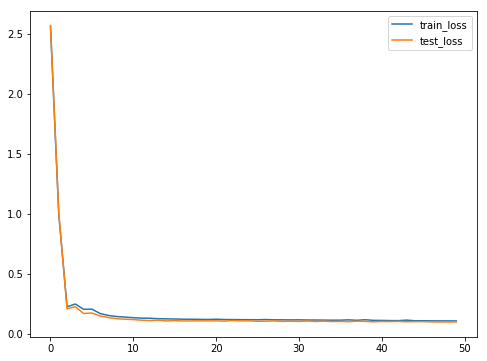

------------------1 fold-------------------
Epoch 46, Train RMSE loss 0.101428925896, Test RMSE loss 0.112766583332.
Epoch 47, Train RMSE loss 0.101748542302, Test RMSE loss 0.113718223452.
Epoch 48, Train RMSE loss 0.100588969324, Test RMSE loss 0.112590639769.
Epoch 49, Train RMSE loss 0.100302917904, Test RMSE loss 0.110263448463.


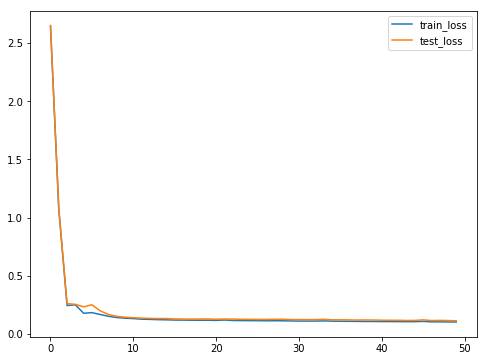

------------------2 fold-------------------
Epoch 46, Train RMSE loss 0.105471509862, Test RMSE loss 0.106024402415.
Epoch 47, Train RMSE loss 0.106707000174, Test RMSE loss 0.105534247233.
Epoch 48, Train RMSE loss 0.103915273495, Test RMSE loss 0.103901467158.
Epoch 49, Train RMSE loss 0.104813657161, Test RMSE loss 0.107190273207.


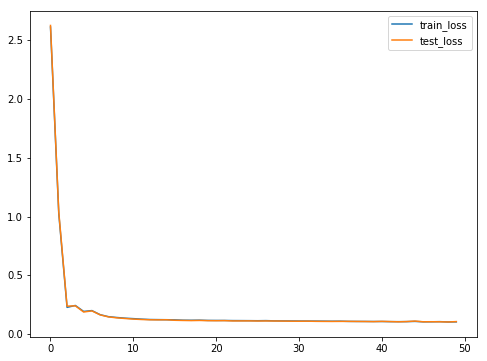

------------------3 fold-------------------
Epoch 46, Train RMSE loss 0.107519578029, Test RMSE loss 0.0934632676168.
Epoch 47, Train RMSE loss 0.109571176465, Test RMSE loss 0.100180933679.
Epoch 48, Train RMSE loss 0.107276272463, Test RMSE loss 0.096703732885.
Epoch 49, Train RMSE loss 0.105681743799, Test RMSE loss 0.0947469714369.


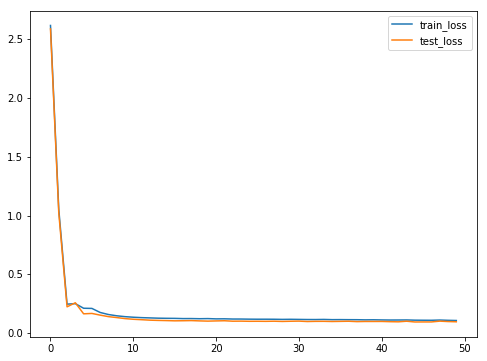

------------------4 fold-------------------
Epoch 46, Train RMSE loss 0.103521367099, Test RMSE loss 0.112357879819.
Epoch 47, Train RMSE loss 0.102932543679, Test RMSE loss 0.111525379398.
Epoch 48, Train RMSE loss 0.102985482794, Test RMSE loss 0.111250237959.
Epoch 49, Train RMSE loss 0.103930079676, Test RMSE loss 0.111667989803.


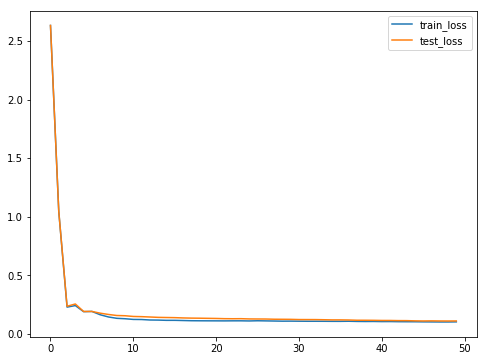

5-fold-validation, Avg Train Loss 0.10421802519, Avg Test loss 0.104375870269.


(0.10421802518990857, 0.10437587026897185)

In [23]:
epochs = 50
verbose_epoch = 45
batch_size = 100
learning_rate = 0.05
weight_decay = 170

k_fold_validation(5, X_train, y_train, epochs, verbose_epoch, batch_size, 
                  learning_rate, weight_decay, ctx=ctx)

Epoch 46, Train RMSE loss 0.105695472863.
Epoch 47, Train RMSE loss 0.104410264663.
Epoch 48, Train RMSE loss 0.105933728909.
Epoch 49, Train RMSE loss 0.105265059433.


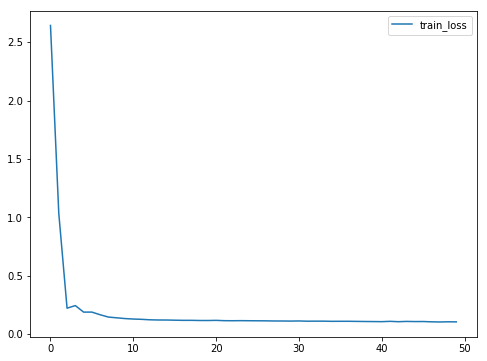

(1459, 1)


In [24]:
def predict(epochs, verbose_epoch, batch_size, learning_rate, weight_decay, ctx):
    net = get_net()
    train(net, X_train, y_train, None, None, epochs, verbose_epoch, batch_size, 
          learning_rate, weight_decay, ctx)
    predict = net(X_test).asnumpy()
    submission = pd.DataFrame()
    submission['Id'] = test_data['Id']
    submission['SalePrice'] = pd.Series(predict.reshape((1, -1))[0])
    submission.to_csv('submission.csv', index=False)
    
predict(epochs, verbose_epoch, batch_size, learning_rate, weight_decay, ctx)